# Predicting Hotel Booking Cancellation

#### By: Julia Kelman: [GitHub](https://github.com/JulKelman)

## Problem Statement

Over the years, the hotel industry has changed with a majority of bookings now made through third parties such as Booking.com [(source)](https://www.hotelmanagement.net/tech/study-cancelation-rate-at-40-as-otas-push-free-change-policy). Those Online Travel Agencies (OTA) have transformed cancellation policies from a footnote at the bottom of the page to the main selling point in their marketing campaigns [(source)](https://triptease.com/blog/the-real-cost-of-free-cancellations/). As a result, customers have become accustomed to free cancellation policies. In fact, a study conducted by D-Edge Hospitality Solutions found that cancellation rate across all channels has risen by 6% over the past four years, reaching almost 40% in 2018 [(source)](https://www.d-edge.com/how-online-hotel-distribution-is-changing-in-europe/). This increase in booking cancellation makes it harder for hotels to accurately forecast, leading to non-optimized occupancy and revenue loss [(source)](https://www.d-edge.com/how-online-hotel-distribution-is-changing-in-europe/). 

When hotels try to protect themselves by using services such as Booking.com's "Risk Free Reservations", the burden then falls on OTAs. Indeed, this service requires the OTA to pay for the reservation if the booking is canceled and they cannot find a new guest to occupy the room [(source)](https://triptease.com/blog/the-real-cost-of-free-cancellations/). One thing is clear, whether you are a hotel or an OTA, cancellations have an negative financial impact on your business.  

In addition to the direct financial consequences of cancellations, they also cause operational problems (such as over or understaffing). Those problems may lead to decrease customer satisfaction and negative reviews. In a world where more and more customers check online reviews before picking a hotel, those reviews can have major impacts. Indeed, TripAdvisor’s reviews and scores influenced around $546 billion of travel spending during 2017 [(source)](https://www.stayntouch.com/blog/how-online-reviews-impact-hotel-revenue/). At a single hotel level, an increase in online reputation score has been linked to an increase in occupancy and revenue [(source)](https://vtechworks.lib.vt.edu/handle/10919/85353). We can clearly understand why avoiding bad reviews due to a room not being ready when the guest arrives can be very valuable for a business. This requires knowing which booking to prioritize. It is therefore very useful for hotels to know which bookings are likely to get canceled in order to plan their operations accordingly.

Characteristics of the booking itself may be good indicators of whether or not a booking will be canceled. For instance, the average length of stay of canceled reservations is 65% higher than non-canceled booking, with a lead time of 60 days [(source)](https://www.d-edge.com/how-online-hotel-distribution-is-changing-in-europe/). Engaging with the reasons why people are cancelling and what types of bookings are being canceled is crucial.

In order to solve this problem, we will use a real life hotel booking dataset to create a customer segmentation analysis in order to gain insights about the customers (and hopefully reasons why they cancel their reservation). We will then build a classification model (including the newly created customer clusters) to predict whether or not a booking will be canceled with the highest accuracy possible.   
This model will allow hotels to predict if a new booking will be canceled or not, manage their business accordingly, and increase their revenue.   

## Executive Summary

Our goal is to build a model able to classify a booking as canceled or not canceled. In order to do so, we used data from the [Hotel Booking Demand Datasets](https://www.sciencedirect.com/science/article/pii/S2352340918315191). The dataset provides data from real bookings scheduled to arrive between July, 1st 2015 and August, 31st 2017 from two hotels in Portugal (a resort in the Algarve region (H1) and a hotel in the city of Lisbon (H2)). Booking data from both hotels share the same structure, with 31 variables describing the 40,060 observations of H1 and 79,330 observations of H2. For a detailed list and description of those variables refer to the [data dictionary](#Data-Dictionary).   
The two hotel datasets were merged into one main dataframe. The dataframe was then cleaned making sure to address any null values, reformat certain features, and engineer new ones. Exploratory analysis included analysis of the cancellation target variable and its relation with other features. Data visualisation tools were used to identify trends and valuable insights from those analysis. A clustering model was then used to create 4 custer segments whose profiles were then analysed. Six models were then presented: baseline, logistic regression, decision tree, bagging classifier, random forest, and neural network. 
The model with the highest test accuracy was selected as our predictive model and a secondary interpretative model was also chosen in order to gain a deeper understanding of factors influencing cancellations. The models were evaluated, and conclusions and recommendations were derived to optimize occupancy, improve operations, and increase a hotel's revenue. 

## Table of Contents

- [Loading Data](#Loading-Data)
    - [Library Imports](#Library-Imports)  
    - [Hotel Data Imports](#Hotel-Data-Imports)
    - [Data Dictionary](#Data-Dictionary)
- [Data Cleaning](#Data-Cleaning) 
    - [Feature Format](#Feature-Format)
    - [Missing Data](#Missing-Data)
    - [Data Types](#Data-Types)
    - [Duplicates](#Duplicates)
    - [Feature Engineering](#Feature-Engineering)
- [Exploratory Data Analysis](#EDA)
    - [Target Variable: Cancellation](#Target-Variable:-Cancellation)
    - [Full Dataset](#Full-Dataset)
- [Customer Segmentation](#Customer-Segmentation)
    - [Clustering Model Preparation](#Clustering-Model-Prep)
    - [K-Prototypes](#K-Prototypes)
    - [Cluster Analysis](#Cluster-Analysis)
- [Model Preparation](#Model-Preparation)
- [Modeling](#Modeling)  
    - [Baseline Model](#Baseline-Model)  
    - [Logistic Regression](#Logistic-Regression)
    - [Decision Tree](#Decision-Tree)
    - [Bagging Classifier](#Bagging-Classifier)
    - [Random Forest](#Random-Forest)
    - [Neural Network](#Neural-Networks)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
    - [Neural Network](#Neural-Network-Evaluation)
        - [Confusion Matrix](#Confusion-Matrix)
        - [Understanding Misclassifications](#Understanding-Misclassifications)
    - [Logistic Regression](#Logistic-Regression-Evaluation)
        - [Coefficients Interpretation](#Coefficients-Interpretation)
- [Conclusion & Recommendations](#Conclusion-&-Recommendations)
- [References](#References)

## Loading Data 

### Library Imports

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import pickle


from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

RANDOM_STATE = 42

In [2]:
pd.set_option('display.max_columns', None)

### Hotel Data Imports

Data gathered from the [Hotel Booking Demand Datasets](https://www.sciencedirect.com/science/article/pii/S2352340918315191).  
The data contains "two datasets with hotel demand data. One of the hotels (H1) is a resort hotel and the other is a city hotel (H2). Both datasets share the same structure, with 31 variables describing the 40,060 observations of H1 and 79,330 observations of H2. Each observation represents a hotel booking. Both datasets comprehend bookings due to arrive between the 1st of July of 2015 and the 31st of August 2017, including bookings that effectively arrived and bookings that were canceled." 

Loading in data for the first hotel, H1, a resort hotel in the region of Algarve in Portugal. 

In [3]:
h1 = pd.read_csv('../data/H1.csv')
h1.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
h1.shape

(40060, 31)

Loading in data for the second hotel, H2, a hotel in the city of Lisbon in Portugal.

In [5]:
h2 = pd.read_csv('../data/H2.csv')
h2.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.5,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-04-02


In [6]:
h2.shape

(79330, 31)

In order to answer our problem statement, we need to combine information from both hotels into one dataframe.  
In order to retain information about which hotel each booking belongs to, we need to add a column recording the hotel associated with the booking. In order to make it easier for modeling later on, the same column `is_h1` will be added to both datasets. Bookings belonging to hotel 1 will have a value of `1` while bookings belonging to hotel 2 will have a value of `0` for this feature. 

In [7]:
# Adding a column to h1 to record that bookings belong to hotel 1:
h1['is_h1'] = 1

# Adding a column to h2 to record that bookings do not belong to hotel 1 (and therefore belong to hotel 2):
h2['is_h1'] = 0

In [8]:
# Combining the two datasets: 
df = pd.concat(objs = [h1, h2], axis = 0)

# Resetting the index
df.reset_index(drop = True, inplace=True)
df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,is_h1
0,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,1
1,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01,1
2,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,1
3,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02,1
4,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03,1


In [9]:
df.shape

(119390, 32)

The final dataset contains 32 features and 119,390 observations. 

### Data Dictionary


|**Feature Name**|**Type**|**Description**|
|:---|:---|:---|
|ADR|Float|Average Daily Rate. Calculated by dividing the sum of all lodging transactions by the total number of staying nights.|
|Adults|Integer|Number of adults.|
|Agent|Categorical|ID of the travel agency that made the booking.|
|ArrivalDateDayOfMonth|Integer|Day of the month of the arrival date.|
|ArrivalDateMonth|Categorical|Month of arrival date with 12 categories: “January” to “December”.|
|ArrivalDateWeekNumber|Integer|Week number of the arrival date.|
|ArrivalDateYear|Integer|Year of arrival date.|
|AssignedRoomType|Categorical|Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons.|
|Babies|Integer|Number of babies.|
|BookingChanges|Integer|Number of changes/amendments made to the booking from the moment the booking was entered on the Property Management System until the moment of check-in or cancellation. Calculated by adding the number of unique iterations that change some of the booking attributes, namely: persons, arrival date, nights, reserved room type or meal.|
|Children|Integer|Number of children. Sum of both payable and non-payable children.|
|Company|Categorical|ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons.|
|Country|Categorical|Country of origin. Categories are represented in the International Standards Organization (ISO) 3155–3:2013 format.|
|CustomerType|Categorical|Type of booking, assuming one of four categories: Contract (when the booking has an allotment or other type of contract associated to it), Group (when the booking is associated to a group), Transient (when the booking is not part of a group or contract, and is not associated to other transient booking), and Transient-party (when the booking is transient, but is associated to at least other transient booking).|
|DaysInWaitingList|Integer|Number of days the booking was in the waiting list before it was confirmed to the customer. Calculated by subtracting the date the booking was confirmed to the customer from the date the booking entered on the Property Management System.|
|DepositType|Categorical|Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: No Deposit (no deposit was made), Non Refund (a deposit was made in the value of the total stay cost), and Refundable (a deposit was made with a value under the total cost of stay). Value calculated based on the payments identified for the booking in the transaction (TR) table before the booking׳s arrival or cancellation date. In case no payments were found the value is “No Deposit”. If the payment was equal or exceeded the total cost of stay, the value is set as “Non Refund”. Otherwise the value is set as “Refundable”.|
|DistributionChannel|Categorical|Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”.|
|IsCanceled|Integer|Value indicating if the booking was canceled (1) or not (0).|
|IsRepeatedGuest|Integer|Value indicating if the booking name was from a repeated guest (1) or not (0). Variable created by verifying if a profile was associated with the booking customer. If so, and if the customer profile creation date was prior to the creation date for the booking on the Property Management System database it was assumed the booking was from a repeated guest.|
|LeadTime|Integer|Number of days that elapsed between the entering date of the booking into the Property Management System and the arrival date. Calculated by subtracting the entering date from the arrival date.|
|MarketSegment|Categotical|Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”.|
|Meals|Categorical|Type of meal booked. Categories are presented in standard hospitality meal packages: Undefined/SC (no meal package), BB (Bed & Breakfast), HB (Half board: breakfast and one other meal – usually dinner), and FB (Full board: breakfast, lunch and dinner).|
|PreviousBookingsNotCanceled|Integer|Number of previous bookings not canceled by the customer prior to the current booking. In case there was no customer profile associated with the booking, the value is set to 0. Otherwise, the value is the number of bookings with the same customer profile created before the current booking and not canceled.|
|PreviousCancellations|Integer|Number of previous bookings that were canceled by the customer prior to the current booking. In case there was no customer profile associated with the booking, the value is set to 0. Otherwise, the value is the number of bookings with the same customer profile created before the current booking and canceled.|
|RequiredCarParkingSpaces|Integer|Number of car parking spaces required by the customer.|
|ReservationStatus|Categorical|Reservation last status, assuming one of three categories: Canceled (booking was canceled by the customer), Check-Out (customer has checked in but already departed), No-Show (customer did not check-in and did inform the hotel of the reason why). 
|ReservationStatusDate|Date|Date at which the last status was set. This variable can be used in conjunction with the `ReservationStatus` to understand when was the booking canceled or when did the customer checked-out of the hotel.|
|ReservedRoomType|Categorical|Code of room type reserved. Code is presented instead of designation for anonymity reasons.|
|StaysInWeekendNights|Integer|Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel. Calculated by counting the number of weekend nights from the total number of nights.|
|StaysInWeekNights|Integer|Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel. Calculated by counting the number of week nights from the total number of nights.|
|TotalOfSpecialRequests|Integer|Number of special requests made by the customer (e.g. twin bed or high floor).|

## Data Cleaning

### Feature Format

Using Snake Case (stylized as snake_case) is the Python best practice. However, the dataset was provided using Camel Camel (stylized as CamelCase). We need reformat the names of all feature names into snake case. In addition, some features included superfluous spaces that should be removed. 

In [10]:
# Creating a function to reformat the feature names:
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()
# Function from https://stackoverflow.com/questions/1175208/elegant-python-function-to-convert-camelcase-to-snake-case

In [11]:
# Reformating the feature names: 
df.columns = df.columns.map(camel_to_snake)

In [12]:
# Removing spaces:
features = ['meal', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'company']
for feature in features: 
    df[feature] = df[feature].str.strip()

### Missing Data 

As models cannot take in null values, it is important to check for and handle missing data before modeling. 

In [13]:
# Checking for missing data
df.isnull().sum()

is_canceled                         0
lead_time                           0
arrival_date_year                   0
arrival_date_month                  0
arrival_date_week_number            0
arrival_date_day_of_month           0
stays_in_weekend_nights             0
stays_in_week_nights                0
adults                              0
children                            4
babies                              0
meal                                0
country                           488
market_segment                      0
distribution_channel                0
is_repeated_guest                   0
previous_cancellations              0
previous_bookings_not_canceled      0
reserved_room_type                  0
assigned_room_type                  0
booking_changes                     0
deposit_type                        0
agent                               0
company                             0
days_in_waiting_list                0
customer_type                       0
adr         

Only 2 features contain missing data: 
- `children` contains 4 observations with missing values. 
- `country` contains 488 rows with missing values. 

The article providing the data stated: "The Property Management System assured no missing data exists in its database tables. However, in some categorical variables like Agent or Company, “NULL” is presented as one of the categories. This should not be considered a missing value, but rather as “not applicable”. For example, if a booking “Agent” is defined as “NULL” it means that the booking did not came from a travel agent."   
As a result, "NULL" values for `agent` and `company` will be changed to `No Agent` and `No Company` for clarity purposes.

In [14]:
# Changing agent value of "NULL" to "No Agent":
df['agent'].replace(to_replace='NULL', value='No Agent', inplace=True)

In [15]:
# Changing company value of "NULL" to "No Company":
df['company'].replace(to_replace='NULL', value='No Company', inplace=True)

As the source mentioned that no missing value should exist, it is surprising to find 4 observations with missing values for the `children` feature. Given that those only represent 0.003% of the data, we believe that it is safer not to use those observations in our analysis and modeling. As a result, we will drop the 4 observations with missing `children` values. 

In [16]:
df.dropna(subset=['children'], inplace=True)

The article gives insights about the missing `country` values stating: "It is also common for hotels not to know the correct nationality of the customer until the moment of check-in. Therefore, even though the capture of data took considered a timespan prior to arrival date, it is understandable that the distribution of some variables differ between non canceled and canceled bookings."   
Given this information, the missing `country` values will be changed to `unknown`. While imputing missing values with `unknown` resolves the issue for primary data analysis, it does not for modeling. However, in an effort to avoid leaking information about which customers canceled their booking or not, the decision was made not to include the `country` feature in the model. 

In [17]:
# Replacing null value for country feature with "unknown"
df['country'].fillna("unknown", inplace=True)

In [18]:
# Checking that no missing values remain:
df.isnull().sum().sum()

0

Our dataset no longer contains any missing values.

### Data Types

In [19]:
# Checking our features' data types:
df.dtypes

is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                              object
company                           

While comparing the data types to the expected data types (in the [data dictionary](#Data-Dictionary)), 2 discrepancies were found: 
- The `children` feature should be of type integer. 
- The `reservation status date` feature should be of datetime type.   

We therefore need to change the type of those 2 features. 

In [20]:
# Changing children to integer type: 
df['children'] = df['children'].astype(int)

# Changing reservation status date to datetime type: 
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

### Duplicates

Given the data was obtained directly from the hotel's Property Management Systems, we do not expect any duplicates. However, it is good practice to ensure our dataset does not contain duplicates. 

In [21]:
# Checking for duplicates: 
df[df.duplicated(keep='first')]

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,is_h1
5,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,No Company,0,Transient,98.00,0,1,Check-Out,2015-07-03,1
22,0,72,2015,July,27,1,2,4,2,0,0,BB,PRT,Direct,Direct,0,0,0,A,A,1,No Deposit,250,No Company,0,Transient,84.67,0,1,Check-Out,2015-07-07,1
43,0,70,2015,July,27,2,2,3,2,0,0,HB,ROU,Direct,Direct,0,0,0,E,E,0,No Deposit,250,No Company,0,Transient,137.00,0,1,Check-Out,2015-07-07,1
138,1,5,2015,July,28,5,1,0,2,0,0,BB,PRT,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,240,No Company,0,Transient,97.00,0,0,Canceled,2015-07-01,1
200,0,0,2015,July,28,7,0,1,1,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,No Company,0,Transient,109.80,0,3,Check-Out,2015-07-08,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119349,0,186,2017,August,35,31,0,3,2,0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,No Company,0,Transient,126.00,0,2,Check-Out,2017-09-03,0
119352,0,63,2017,August,35,31,0,3,3,0,0,BB,SWE,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,No Company,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03,0
119353,0,63,2017,August,35,31,0,3,3,0,0,BB,SWE,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,No Company,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03,0
119354,0,63,2017,August,35,31,0,3,3,0,0,BB,SWE,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,No Company,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03,0


Our dataset contains duplicates. However, it is possible that multiple bookings with the same features were made on the same say. Since we do not have a feature such as "booking ID", we cannot say for sure that those are true duplicates which makes deleting those "duplicates" questionable.  
Note: For modeling purposes, models were run with and without the duplicates and greater predictive power was found when the "duplicates" were included. As a result, we will keep the "duplicates". 

### Feature Engineering

The original dataset provides a custumer's arrival date with day, month, and year each in a separate feature. For analysis purposes, it is easier to have all of those elements combined into one `arrival_date_full` feature. 

In [22]:
# Creating the arrival date full feature: 
df['arrival_date_full'] = df['arrival_date_year'].astype(str) + "-" + df['arrival_date_month'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}).astype(str) + "-" + df['arrival_date_day_of_month'].astype(str)
df['arrival_date_full'] = pd.to_datetime(df['arrival_date_full'], format="%Y-%m-%d")

The original dataset provides both the `arrival date` (date when the customer is supposed to arrive) and the `reservation status date` (date at which the last status change was made in the property management system). For customers who canceled their booking, the `reservation status date` represents the date when the booking was canceled. For customers who did not cancel their booking, the `reservation status date` represents the date when the guest checked-out of the hotel.   
As a result, calculating the difference between the `arrival date` and the `reservation status date` tells us how many days prior to supposed arrival a customer canceled their booking (for canceled reservations) OR how many days a guest stayed at the hotel (for not canceled reservations). 

In [23]:
# Creating a new feature representing length of stay or how many days before arrival did the customer cancel:
df['status_minus_arrival_date'] = np.abs(df['arrival_date_full'] - df['reservation_status_date']).astype(str)
# formating the feature 
def format_lenght(date):
    return date[0]
df['status_minus_arrival_date'] = df['status_minus_arrival_date'].map(format_lenght).astype(int)

## EDA

### Target Variable: Cancellation

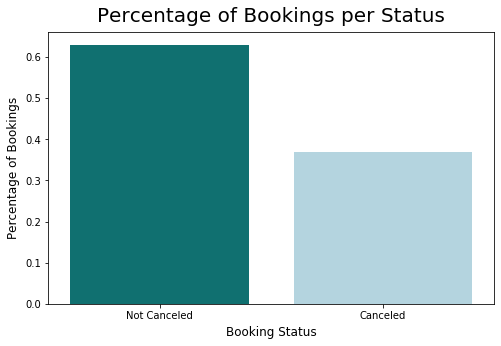

In [24]:
# Visualizing the percentage of canceled vs not canceled bookings: 
plt.figure(figsize=(8,5)) 
plt.title("Percentage of Bookings per Status", fontsize = 20, pad = 10)
sns.barplot(x=df['is_canceled'].unique(), y=df['is_canceled'].value_counts(normalize=True), palette=['teal', 'lightblue'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Percentage of Bookings", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

**Interpretation:** 37% of bookings were canceled. This is line with the 40% cancellation rate reported by the [D-Edge Study](https://www.d-edge.com/how-online-hotel-distribution-is-changing-in-europe/).

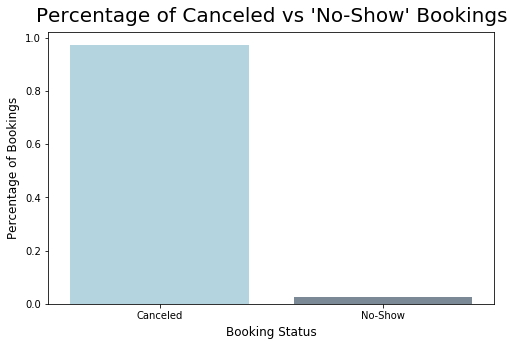

In [25]:
# Visualizing the percentage of bookings canceled prior to arrival: 
plt.figure(figsize=(8,5)) 
plt.title("Percentage of Canceled vs 'No-Show' Bookings", fontsize = 20, pad = 10)
sns.barplot(x=df[df['is_canceled']==1]['reservation_status'].unique(), y=df[df['is_canceled']==1]['reservation_status'].value_counts(normalize=True), palette=['lightblue', 'lightslategrey'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Percentage of Bookings", fontsize = 12, labelpad = 5);

**Interpretation:** A vast majority of bookings (97%) are canceled prior to arrival. 

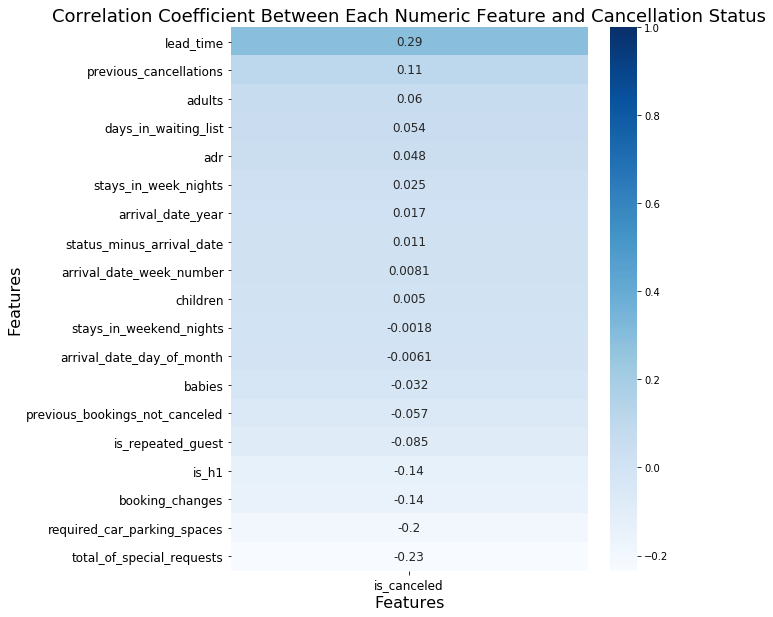

In [26]:
# Visualizing correlation coefficients between features and cancellation:
fig = plt.figure(figsize=(8,10))
ax = sns.heatmap(df.corr()[['is_canceled']].sort_values('is_canceled', ascending=False), annot = True, annot_kws = {"size":12}, cmap='Blues')
ax.set_title('Correlation Coefficient Between Each Numeric Feature and Cancellation Status', fontsize=18)
ax.set_xlabel('Features', fontsize = 16)
ax.set_ylabel('Features', fontsize = 16)
ax.tick_params(axis = "both", labelsize = 12);
y_min, y_max = ax.get_ylim()
ax.set_ylim(top=y_max+1);

**Interpretation:** 
- `Lead time` is the most highly correlated feature with whether or not a booking is canceled. It makes sense that as the number of days between when the booking is made and the supposed arrival date increases, customers have more time to cancel the reservation and there is more time for an unforeseen circumstance derailing travel plans to arise. 
- Interestingly, the `total number of special requests` is the second feature with the strongest correlation to our `cancellation` target. As the number of special requests made increases, the likelihood that a booking is canceled decreases. This suggests that engagement with the hotel prior to arrival and feeling like their needs are heard may make a customer less likely to cancel their reservation.
- Related to special requests, the number of `required car parking spaces` is the third feature with the strongest correlation to our `cancellation` target. As the number of parking spaces requests increases, the likelihood that a booking is canceled decreases. Potential reasons for this relationship are discussed later on. 
- Interestingly, a customer's prior history with the hotel (measured by the number of `previous bookings not canceled`  or whether or not a customer `is a repeated guest`) does not seem to be highly correlated with whether or not the current booking will be canceled. On the other hand, a customer's prior history of cancellation (measured by the number of `previous cancellations` is more highly correlated with whether or not the current booking will be canceled. 

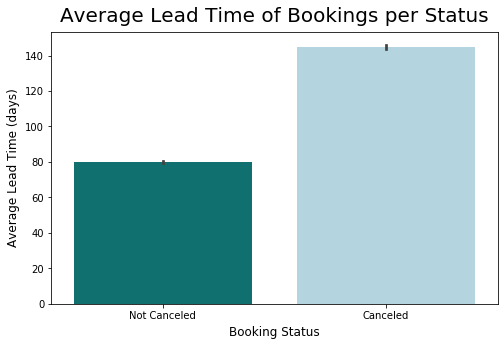

In [27]:
# Visualizing the average lead time for canceled and not canceled bookings:
plt.figure(figsize=(8,5)) 
plt.title("Average Lead Time of Bookings per Status", fontsize = 20, pad = 10)
sns.barplot(x=df['is_canceled'], y=df['lead_time'], palette=['teal', 'lightblue'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Average Lead Time (days)", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

**Interpretation:** Canceled bookings have a longer lead time on average. Potential reasons why were discussed above. 

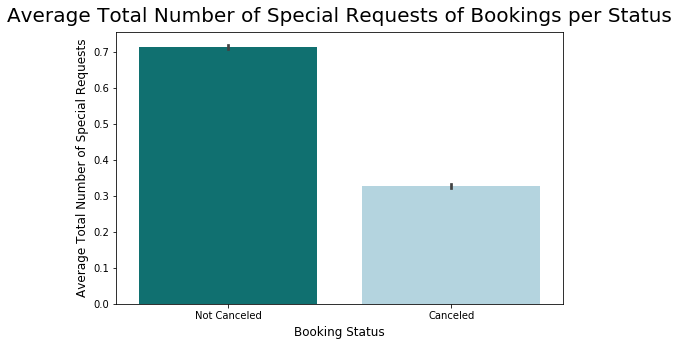

In [28]:
# Visualizing the total number of special requests for canceled and not canceled bookings:
plt.figure(figsize=(8,5)) 
plt.title("Average Total Number of Special Requests of Bookings per Status", fontsize = 20, pad = 10)
sns.barplot(x=df['is_canceled'], y=df['total_of_special_requests'], palette=['teal', 'lightblue'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Average Total Number of Special Requests", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

**Interpretation:** Customers who cancel their bookings make on average fewer special requests. Potential reasons why were discussed above. 

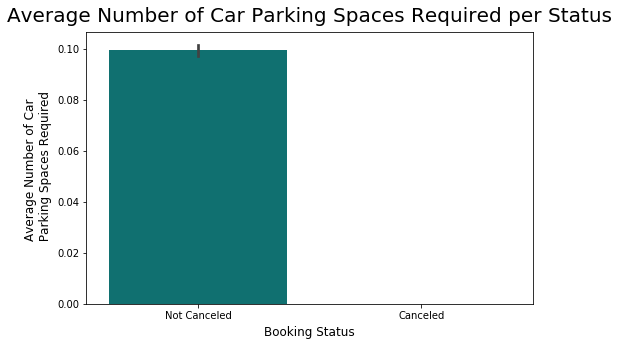

In [29]:
# Visualizing the total number of requested parking spaces for canceled and not canceled bookings:
plt.figure(figsize=(8,5)) 
plt.title("Average Number of Car Parking Spaces Required per Status", fontsize = 20, pad = 10)
sns.barplot(x=df['is_canceled'], y=df['required_car_parking_spaces'], palette=['teal', 'lightblue'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Average Number of Car \n Parking Spaces Required", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

**Interpretation:** On average, customers who do not cancel their bookings tend to require more parking spaces. Similarly to the number of special requests, it would make sense that the more a customer engages with the hotel (by putting in a  request for a parking spot), the less likely they are to cancel. It is also fair to think that by the time a guest is thinking about where they will park their car, they are most likely pretty commited to their destination. Finally, thinking about this from the hotel perpective, it is possible that not many hotels around have a parking. As a result, the need for a parking space would limit the customer in their hotel options and make them less likely to cancel. More information would be required from the hotel directly to confirm this theory. However, if true, this suggests that adding parking spaces could be a way to help reduce cancellations. 

In [30]:
# Created a dataframe of canceled bookings for plotting purposes
canceled = df[df['is_canceled']==1][['arrival_date_full']]
canceled.set_index('arrival_date_full', inplace=True)
canceled['count'] = 1
canceled=canceled.resample('M').sum()

# Created a dataframe of not canceled bookings for plotting purposes
not_canceled = df[df['is_canceled']==0][['arrival_date_full']]
not_canceled.set_index('arrival_date_full', inplace=True)
not_canceled['count'] = 1
not_canceled=not_canceled.resample('M').sum()

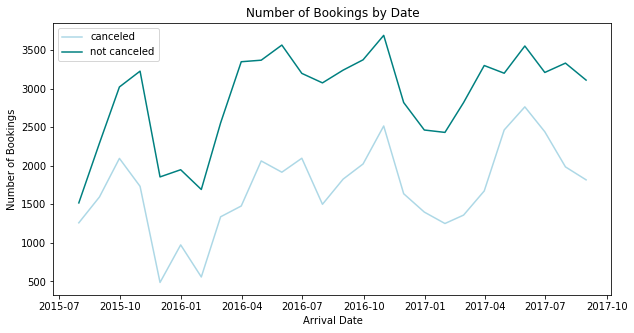

In [31]:
# Visualizing the number of canceled and not canceled bookings by date:
plt.figure(figsize=(10,5))
sns.lineplot(x=canceled.index, y=canceled['count'], color='lightblue')
sns.lineplot(x=not_canceled.index, y=not_canceled['count'], color='teal')
plt.ylabel('Number of Bookings')
plt.xlabel('Arrival Date')
plt.title('Number of Bookings by Date')
plt.legend(['canceled', 'not canceled']);

**Interpretation:** The same pattern can be seen in both canceled and non-canceled bookings. Less bookings are canceled (or kept) around January. More bookings are canceled (and kept) in the warmer months between April and July. 

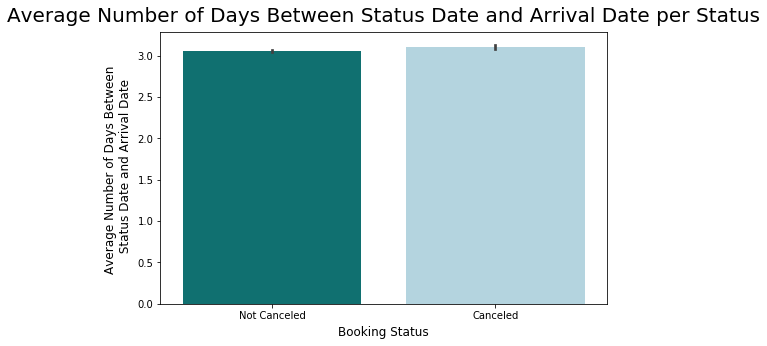

In [32]:
# Visualizing the average number of days between status date and arrival date for canceled and not canceled bookings:
plt.figure(figsize=(8,5)) 
plt.title("Average Number of Days Between Status Date and Arrival Date per Status", fontsize = 20, pad = 10)
sns.barplot(x=df['is_canceled'], y=df['status_minus_arrival_date'], palette=['teal', 'lightblue'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Average Number of Days Between \n Status Date and Arrival Date", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

**Interpretation:** 
- On average customers spend 3 nights in the hotel 
- On average, customers cancel 3 days before their supposed arrival date. This does not give hotels a lot of time to find a new guest or adjust their operations. This is further evidence for the need of a predictive model able to identify which bookings will be canceled earlier. 

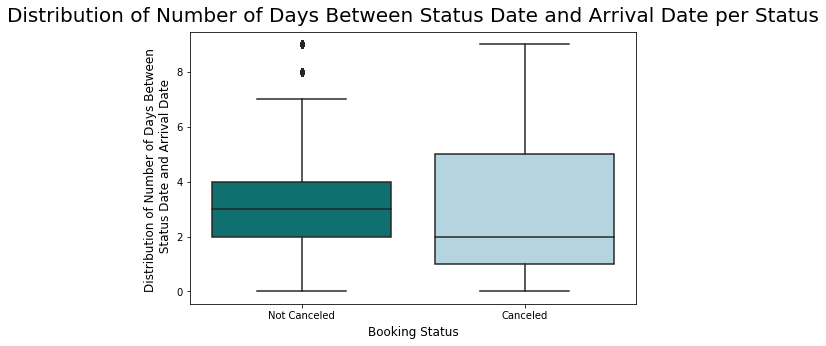

In [33]:
# Visualizing the distribution of number of days between status date and arrival date for canceled and not canceled bookings:
plt.figure(figsize=(8,5)) 
plt.title("Distribution of Number of Days Between Status Date and Arrival Date per Status", fontsize = 20, pad = 10)
sns.boxplot(x=df['is_canceled'], y=df['status_minus_arrival_date'], palette=['teal', 'lightblue'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Distribution of Number of Days Between \n Status Date and Arrival Date", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

**Interpretation:** There seems to be more variation in how many days prior to arrival customers cancel their bookings compared to the number of days customers stay at a hotel.   
We do notice 2 outliers in the length of stay. However, there is no reason to believe stays over 8 days are not valid datapoints. As a result, we will keep those outliers in our model. 

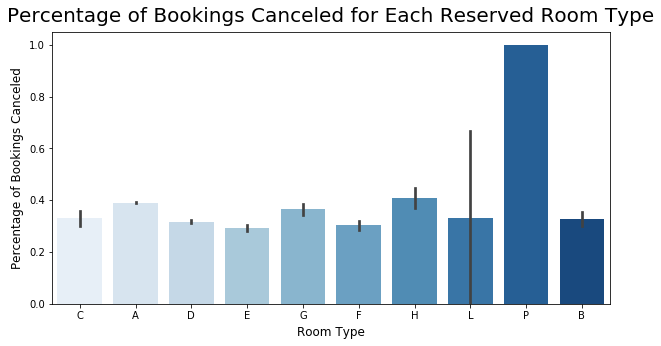

In [34]:
# Visualizing percentage of bookings canceled for each room type:
plt.figure(figsize=(10,5)) 
plt.title("Percentage of Bookings Canceled for Each Reserved Room Type", fontsize = 20, pad = 10)
sns.barplot(x=df['reserved_room_type'], y=df['is_canceled'], palette='Blues')
plt.xlabel("Room Type", fontsize = 12, labelpad = 5)
plt.ylabel("Percentage of Bookings Canceled", fontsize = 12, labelpad = 5);

**Interpretation:** Customers who reserved room type P have the highest percentage booking cancellation with 100% of bookings canceled. As the dataset did not provide the actual room designations for anonymity purposes, it is hard to interpret why bookings of room type P are canceled more often. 

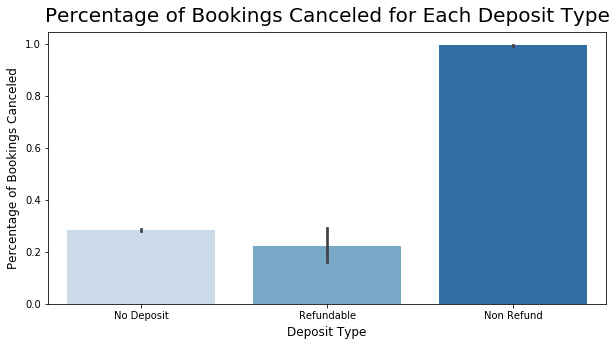

In [35]:
# Visualizing percentage of bookings canceled for each deposit type:
plt.figure(figsize=(10,5)) 
plt.title("Percentage of Bookings Canceled for Each Deposit Type", fontsize = 20, pad = 10)
sns.barplot(x=df['deposit_type'], y=df['is_canceled'], palette='Blues')
plt.xlabel("Deposit Type", fontsize = 12, labelpad = 5)
plt.ylabel("Percentage of Bookings Canceled", fontsize = 12, labelpad = 5);

**Interpretation:** Surprisingly, customers who pay a non-refundable deposit have a much higher percentage of canceled reservations. As this is a counter-intuitive finding, it is necessary to dig a little deeper into the characteristics of bookings with a non-refundable deposit. 

In [36]:
df.groupby(df['deposit_type']).describe(include='all')

is_canceled                                                      \
                   count unique top freq first last      mean       std  min   
deposit_type                                                                   
No Deposit      104637.0    NaN NaN  NaN   NaN  NaN  0.283743  0.450816  0.0   
Non Refund       14587.0    NaN NaN  NaN   NaN  NaN  0.993624  0.079595  0.0   
Refundable         162.0    NaN NaN  NaN   NaN  NaN  0.222222  0.417029  0.0   

                                 lead_time                             \
              25%  50%  75%  max     count unique top freq first last   
deposit_type                                                            
No Deposit    0.0  0.0  1.0  1.0  104637.0    NaN NaN  NaN   NaN  NaN   
Non Refund    1.0  1.0  1.0  1.0   14587.0    NaN NaN  NaN   NaN  NaN   
Refundable    0.0  0.0  0.0  1.0     162.0    NaN NaN  NaN   NaN  NaN   

                                                                       \
                    mean         std  min    25%    50%    75%    max   
deposit_type                                                            
No Deposit     88.759894   92.992299  0.0   14.0   56.0  138.0  737.0   
Non Refund    212.908891  133.324402  0.0  103.0  183.0  304.0  629.0   
Refundable    152.098765   97.581768  0.0   64.5  169.0  169.0  385.0   

             arrival_date_year                                          \
                         count unique top freq first last         mean   
deposit_type                                                             
No Deposit            104637.0    NaN NaN  NaN   NaN  NaN  2016.174059   
Non Refund             14587.0    NaN NaN  NaN   NaN  NaN  2016.031466   
Refundable               162.0    NaN NaN  NaN   NaN  NaN  2016.141975   

                                                                \
                   std     min     25%     50%     75%     max   
deposit_type                                                     
No Deposit    0.702815  2015.0  2016.0  2016.0  2017.0  2017.0   
Non Refund    0.730267  2015.0  2015.0  2016.0  2017.0  2017.0   
Refundable    0.415047  2015.0  2016.0  2016.0  2016.0  2017.0   

             arrival_date_month                                                \
                          count unique        top   freq first last mean  std   
deposit_type                                                                    
No Deposit               104637     12     August  12958   NaN  NaN  NaN  NaN   
Non Refund                14587     12  September   1953   NaN  NaN  NaN  NaN   
Refundable                  162      9      March     83   NaN  NaN  NaN  NaN   

                                      arrival_date_week_number             \
              min  25%  50%  75%  max                    count unique top   
deposit_type                                                                
No Deposit    NaN  NaN  NaN  NaN  NaN                 104637.0    NaN NaN   
Non Refund    NaN  NaN  NaN  NaN  NaN                  14587.0    NaN NaN   
Refundable    NaN  NaN  NaN  NaN  NaN                    162.0    NaN NaN   

                                                                             \
             freq first last       mean        std   min   25%   50%    75%   
deposit_type                                                                  
No Deposit    NaN   NaN  NaN  27.135115  13.645547   1.0  16.0  28.0  38.00   
Non Refund    NaN   NaN  NaN  27.448619  13.331718   1.0  17.0  25.0  39.00   
Refundable    NaN   NaN  NaN  20.932099   9.797405  12.0  14.0  14.0  21.75   

                   arrival_date_day_of_month                             \
               max                     count unique top freq first last   
deposit_type                                                              
No Deposit    53.0                  104637.0    NaN NaN  NaN   NaN  NaN   
Non Refund    53.0                   14587.0    NaN NaN  NaN   NaN  NaN   
Refundable  

**Interpretation:** Non-refundable deposits seem to be made more often by transient groups who use a travel agent. This suggests that the hotels may have policies about requiring certain groups to make a non-refundable deposit. Those groups may be considered "high risk" and very likely to cancel. More information would be required from the hotels about their deposit policies in order to confirm this hypothesis. 

### Full Dataset

In [37]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_h1,status_minus_arrival_date
count,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000,119386.000000
mean,0.370395,104.014801,2016.156593,27.165003,15.798553,0.927605,2.500310,1.856390,0.103890,0.007949,0.031913,0.087121,0.137102,0.221131,2.321227,101.833541,0.062520,0.571340,0.335550,3.077270
std,0.482913,106.863286,0.707456,13.605334,8.780783,0.998618,1.908289,0.579261,0.398561,0.097438,0.175770,0.844350,1.497462,0.652315,17.595011,50.534664,0.245295,0.792798,0.472184,2.135633
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.590000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000,1.000000,4.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000,1.000000,9.000000


**Interpretation:** The `adr` feature (average daily rate) seems to have outliers. With a minimum of -6.38 and a maximum of 5400. A negative ADR could be possible if a hotel had to compensate a guest for some reason. While those numbers are surprising, we do not have enough information to assure that those observations are not accurate datapoints.   
Note: For modeling puposes, we ran our model with and without those outliers and removing them lead to a decrease in predictive power. As a result, we did not remove those observations. 

## Customer Segmentation

The goal is to divide our customers into clusters and analyze those clusters in order to gain a better understanding of the hotel guests. In addition, those clusters can be added as a feature in our model in order to improve its predictive power.  

### Clustering Model Prep

We do not want to leak any information about our target (cancellation) into our clusters since those clusters will later be used as features in our predictive model. As a result, we must remove `is_canceled`, `reservation_status`, and `country` from our X variable.   
The agent and company IDs recorded in the `agent` and `company` features include a large amount of categorical data that is de-identified and therefore difficult to interpret. As a result, those features were not included in the clustering model. Finally, as models cannot take in datetime objects as features, the `reservation_status_date` and `arrival_date_full` features were also excluded from the clustering model. It is worth noting that information about the arrival date is still included in the clustering model thanks to the `arrival_date_year`, `arrival_date_month`, and `arrival_date_day_of_month` features. 

In [38]:
X = df.drop(columns=['is_canceled', 'reservation_status', 'agent', 'company', 'country', 'reservation_status_date', 'arrival_date_full'])

In [39]:
X.head()

,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_h1,status_minus_arrival_date
0,342,2015,July,27,1,0,0,2,0,0,BB,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,1,0
1,737,2015,July,27,1,0,0,2,0,0,BB,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,1,0
2,7,2015,July,27,1,0,1,1,0,0,BB,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,1,1
3,13,2015,July,27,1,0,1,1,0,0,BB,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,1,1
4,14,2015,July,27,1,0,2,2,0,0,BB,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,1,2


Since our data is a mix of categorical and numeric features, K-prototypes is the most appropriate model to create clusters.  
Note: K-Means, DBSCAN, and KModes were also tested but not shown in this notebook as Kprototypes was the best suited for our data. 

### K-Prototypes

In order to identify the best number of clusters to create, we need to evaluate the K-Protypes costs for different numbers of clusters. Here, we will try creating 3 to 7 clusters.   
Note: Creating 2 and 8 clusters was also tested. However, for time and computation efficiency, those were not included in this notebook. 

In [40]:
# Creating a loop to try our different number of clusters: 
kproto_costs = []
for n in range(3, 8):
    #do the clustering 
    kproto = KPrototypes(n_clusters=n, init='Huang', verbose=0, random_state=RANDOM_STATE, n_jobs=-1)
    clusters = kproto.fit_predict(X, categorical=[2, 10, 11, 12, 13, 16, 17, 19, 21, 25])
    print(f'cost: {kproto.cost_}')
    print(f'iter: {kproto.n_iter_}')
    
    # get cost 
    cost = kproto.cost_
    
    #gather them
    kproto_costs.append((n, cost))

cost: 647695770.6494106
iter: 20
cost: 522850049.57898057
iter: 12
cost: 458967739.3715904
iter: 29
cost: 412755852.84647894
iter: 25
cost: 377435366.55342966
iter: 49


In [42]:
# Creating a dataframe for our K-Prototypes clusters: 
kproto_costs_df = pd.DataFrame(kproto_costs, columns=['n', 'cost'])
kproto_costs_df

,n,cost
0,3,6.476958e+08
1,4,5.228500e+08
2,5,4.589677e+08
3,6,4.127559e+08
4,7,3.774354e+08


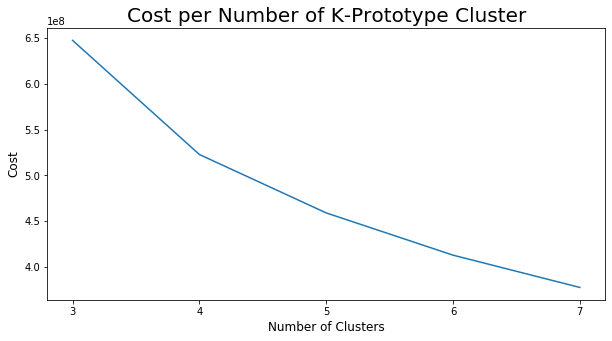

In [87]:
# Visualizing the K-prototype costs:
plt.figure(figsize=(10,5))
plt.plot(kproto_costs_df['n'], kproto_costs_df['cost'])
plt.xticks([3,4,5,6,7])
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Cost', size=12)
plt.title('Cost per Number of K-Prototype Cluster', size=20);

**Interpretation:** We can see a "dip" in cost for n = 4 clusters. As a result, we will create 4 clusters.

In [46]:
# Creating the 4 customer clusters:
kproto_4 = KPrototypes(n_clusters=4, init='Huang', verbose=0, random_state=RANDOM_STATE, n_jobs=-1)
clusters = kproto_4.fit_predict(X, categorical=[2, 10, 11, 12, 13, 16, 17, 19, 21, 25])
print(f'cost: {kproto_4.cost_}')

cost: 522850049.57898057


Given the computational and time expense of creating those clusters, we will save our final kproto_4 model. 

In [47]:
# Pickling the kproto_4 model: 
pickle.dump(kproto_4, open('../models/kproto_4.p', 'wb'))

### Cluster Analysis

In order to analyze the clusters, we first need to save them as a feature. 

In [44]:
# Creating a "clusters" feature in our dataset:
df['clusters'] = clusters

In [55]:
pd.set_option('display.max_rows', None)
df.groupby(df['clusters']).describe(include='all').T

clusters                                                 0  \
is_canceled                    count                 23347   
                               unique                  NaN   
                               top                     NaN   
                               freq                    NaN   
                               first                   NaN   
                               last                    NaN   
                               mean               0.347582   
                               std                0.476213   
                               min                       0   
                               25%                       0   
                               50%                       0   
                               75%                       1   
                               max                       1   
lead_time                      count                 23347   
                               unique                  NaN   
                               top                     NaN   
                               freq                    NaN   
                               first                   NaN   
                               last                    NaN   
                               mean                43.2734   
                               std                 35.8053   
                               min                       0   
                               25%                      12   
                               50%                      35   
                               75%                      70   
                               max                     194   
arrival_date_year              count                 23347   
                               unique                  NaN   
                               top                     NaN   
                               freq                    NaN   
                               first                   NaN   
                               last                    NaN   
                               mean                2016.27   
                               std                0.691489   
                               min                    2015   
                               25%                    2016   
                               50%                    2016   
                               75%                    2017   
                               max                    2017   
arrival_date_month             count                 23347   
                               unique                   12   
                               top                  August   
                               freq                   5185   
                               first                   NaN   
                               last                    NaN   
                               mean                    NaN   
                               std                     NaN   
                               min                     NaN   
                               25%                     NaN   
                               50%                     NaN   
                               75%                     NaN   
                               max                     NaN   
arrival_date_week_number       count                 23347   
                               unique                  NaN   
                               top                     NaN   
                               freq                    NaN   
                               first                   NaN   
                               last                    NaN   
                               mean                28.7558   
                               std                 9.87029   
                               min                       1   
                               25%                      21   
                               50%                      30   
                               7

**Interpretation**:  

**Cluster 0:**   
- Family: higher mean number of children and babies 
- Higher average daily room price 
- Average number of special requests slightly higher 
- Most frequent arrival date month: August

All of those characteristics make sense for a family. Indeed, families may be willing to pay more for extra space and comfort in their room. In addition, they may need to make more special requests (such as asking for a crib in the room). Finally, as children do not have school in August and many companies in Europe offer vacation time during that month, it is the most common month for families to travel. As a result, **cluster 0 will now be refered to as `The Family` cluster**.

**Cluster 1:** 
- Low cancellation percentage: 25%
- Last minute planners: mean `lead time` of 31 days 
- Return customer: higher mean number of previous bookings not canceled   

All those characteristics make sense for return customers. They may plan their trip more last minute since they are already familiar with the destination and hotel and may be less likely to cancel. As a result, **cluster 1 will now be refered to as `The Return Customer` cluster**.  

**Cluster 2:**   
- High Cancellation percentage: 64%
- Planners: mean `lead time` 326 days
- Higher mean number of previous cancellations 
- Higher mean number of days in waiting list
- Most frequent arrival date month: September  
- Most frequent market segment: Groups 
- Do not use a travel agent   

Those characteristics seem to describe a group of younger customers trying to plan a vacation in advance. Indeed, September is a very common month for college aged individuals to travel in Europe. Indeed, many college programs do not start until October in Europe and as a result, group of young friends like to travel in September right after the peak vacation season in August. Anybody who has tried to plan a vacation with friends in their 20s in advance knows that those reservations have a very good chance of being canceled. As a result, **cluster 2 will now be refered to as `The Cancellation Squad` cluster**. 

**Cluster 3:**   
- mid cancellation (0.45)
- Higher weekend and week nights average   

Those characteristics seem to describe individuals who plan longer stays. As a result, **cluster 3 will now be refered to as `The Extended Stay` cluster**. 

In [45]:
# Renaming the clusters:
df['clusters'] = df['clusters'].map({0:'The Family', 1:'The Return Customer', 2:'The Cancellation Squad', 3:'The Extended Stay'})

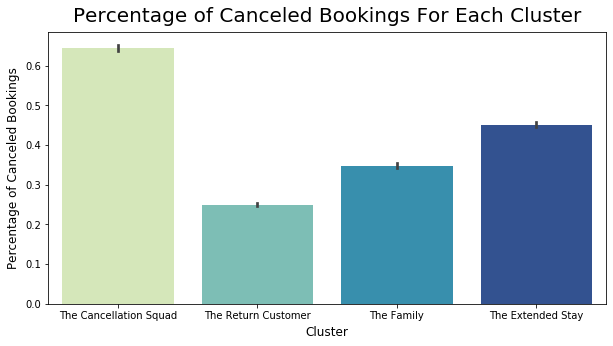

In [46]:
# Visualizing the percentage of canceled bookings for each cluster: 
plt.figure(figsize=(10,5)) 
plt.title("Percentage of Canceled Bookings For Each Cluster", fontsize = 20, pad = 10)
sns.barplot(x=df['clusters'], y=df['is_canceled'], palette='YlGnBu')
plt.xlabel("Cluster", fontsize = 12, labelpad = 5)
plt.ylabel("Percentage of Canceled Bookings", fontsize = 12, labelpad = 5);

**Interpretation:** The cancellation squad cluster has the highest percentage of canceled bookings while the return customer cluster has the lowest. 

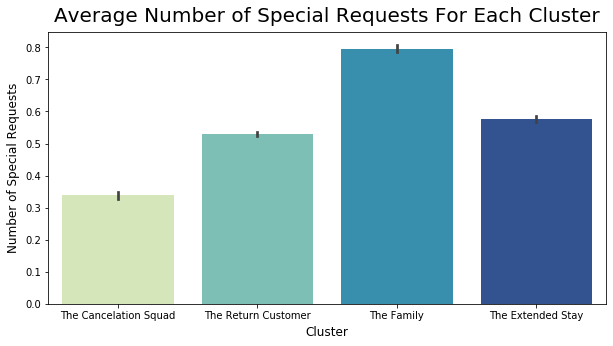

In [153]:
# Visualizing the total number of special requests for each cluster: 
plt.figure(figsize=(10,5)) 
plt.title("Average Number of Special Requests For Each Cluster", fontsize = 20, pad = 10)
sns.barplot(x=df['clusters'], y=df['total_of_special_requests'], palette='YlGnBu')
plt.xlabel("Cluster", fontsize = 12, labelpad = 5)
plt.ylabel("Number of Special Requests", fontsize = 12, labelpad = 5);

**Interpretation:** Customers who are part of the family cluster tend to make the most requests (as discussed above) while customers who belong to the cancellation squad cluster tend to make the least amount of requests. 

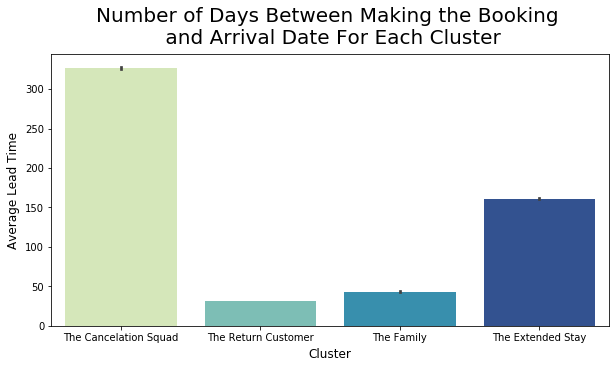

In [152]:
# Visualizing the average lead time for each cluster: 
plt.figure(figsize=(10,5)) 
plt.title("Number of Days Between Making the Booking \n and Arrival Date For Each Cluster", fontsize = 20, pad = 10)
sns.barplot(x=df['clusters'], y=df['lead_time'], palette='YlGnBu')
plt.xlabel("Cluster", fontsize = 12, labelpad = 5)
plt.ylabel("Average Lead Time", fontsize = 12, labelpad = 5);

**Interpretation:** Members of the cancellation squad cluster tend to make their bookings a lot earlier than members of the other clusters. 

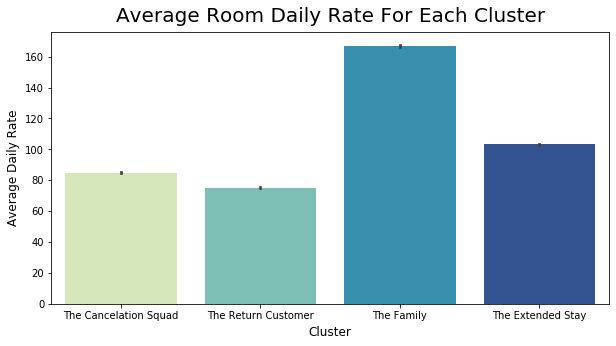

In [102]:
# Visualizing the average daily room rate for each cluster: 
plt.figure(figsize=(10,5)) 
plt.title("Average Room Daily Rate For Each Cluster", fontsize = 20, pad = 10)
sns.barplot(x=df['clusters'], y=df['adr'], palette='YlGnBu')
plt.xlabel("Cluster", fontsize = 12, labelpad = 5)
plt.ylabel("Average Daily Rate", fontsize = 12, labelpad = 5);

**Interpretation:** Members of the family cluster tend to spend more money for their room compared to the other clusters.  

## Model Preparation

We do not want to leak any information about our target (cancellation) into our model. As a result, we must remove `is_canceled`, `reservation_status`, and `country` from our X variable.   
The agent and company IDs recorded in the `agent` and `company` features include a large amount of categorical data that is de-identified and therefore difficult to interpret. Since information about the type of agent and company used is included in the `market_segment` and `distribution_channel` features, the `agent` and `company` features were not included in the model.   
Finally, as models cannot take in datetime objects as features, the `reservation_status_date` and `arrival_date_full` features were also excluded from the clustering model. It is worth noting that information about the arrival date is still included in the model thanks to the `arrival_date_year`, `arrival_date_month`, and `arrival_date_day_of_month` features. In addition, information about the reservation status date was used to generate the `status_minus_arrival_date` feature. 

In [154]:
df = pd.get_dummies(df, columns=['arrival_date_month', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'clusters'])

In [156]:
X = df.drop(columns=['is_canceled','reservation_status', 'agent', 'company', 'country', 
                     'reservation_status_date', 'arrival_date_full'])
y = df['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, stratify=y, test_size=0.15)

## Modeling

Our goal is to build a model able to predict whether or not a booking will be canceled with the highest level of accuracy. In order to do so, our baseline model was compared to a logistic regression, a decision tree, a bagging classifier, a random forest, and a feed forward neural network.   
Note: A kNN, Gaussian Naive Bayes, and SVM models were also tested. However, for computation efficiency and time purporses, those models will not be shown in this notebook as they did not perform as well as the other models. 

### Baseline Model

In [157]:
# Checking baseline model score 
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
print(f'Baseline Training Score: {dummy.score(X_train, y_train)}')
print(f'Baseline Testing Score: {dummy.score(X_test, y_test)}')

Baseline Training Score: 0.6296044462839236
Baseline Testing Score: 0.6296068796068796


**Interpretation:** If we always predicted the majority class (Not Canceled), our "model" would have a 63% accuracy. 

### Logistic Regression

In [158]:
# Construct Grid Parameters
lg_params = {
    'penalty': ['l1'], 
    'C': [3.5],
    'max_iter': [300]
}

# Perform Grid Search
lg_gs = GridSearchCV(LogisticRegression(solver='liblinear', random_state=RANDOM_STATE),
                 lg_params,
                 cv = 5,
                 scoring = 'accuracy')
lg = lg_gs.fit(X_train, y_train)

In [159]:
# Scoring 
print(f'Best Training Accuracy: {lg.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {lg.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(lg.best_estimator_, X, y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 0.8135457931768462
Best Testing Accuracy: 0.8124301987938352
Cross-val-score: 0.8131690261446602


In [187]:
pickle.dump(lg, open('../models/logreg.p', 'wb'))

**Interpretation:** This model is not overfit or underfit (the training and testing scores are close together). The model is outperforming the baseline with a **testing accuracy of 81.2%**. The cross-val-score being very close to the testing score indicates that our testing set is a valid representation of the data.    
Note: More parameters than the ones appearing above were investigated during our search for the best model. However, in order to decrease runtime, only the parametters giving us the best test score (identified using `.best_params_`) were included in this notebook.   

Since the logistic regression model does not provide predictive power as high as we would like, we will attempt a more complex Decision Tree model next. 

### Decision Tree

In [161]:
# Construct Grid Parameters
dt_params = {
    'max_depth':[None],
    'max_features' : [0.7],
    'min_samples_split': [25], 
    'min_samples_leaf': [1]
}

# Perform Grid Search
dt_gs = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE),
                 dt_params,
                 cv = 5,
                 scoring = 'accuracy')
dt = dt_gs.fit(X_train, y_train)

In [162]:
# Scoring 
print(f'Best Training Accuracy: {dt.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {dt.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(dt.best_estimator_, X, y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 0.9590354559608979
Best Testing Accuracy: 0.9355595264686174
Cross-val-score: 0.9388454372506991


In [186]:
pickle.dump(dt, open('../models/dtree.p', 'wb'))

**Interpretation:** This model is slightly overfit with a training score of 95.6% higher than our **93.6% accuracy testing score**. The cross-val-score being very close to the testing score indicates that our testing set is a valid representation of the data. Although our model is slightly overfit, the high testing score indicates that it still provides high predictive power.      
Note: More parameters than the ones appearing above were investigated during our search for the best model. However, in order to decrease runtime, only the parametters giving us the best test score (identified using `.best_params_`) were included in this notebook.   

Since our Decision Tree model is overfit, we will try a Bagging Classifier model next in order to increase performance and reduce variance. 

### Bagging Classifier

In [164]:
# Construct Grid Parameters
bc_params = {
    'n_estimators': [45], 
    'max_features': [0.8]
}

# Perform Grid Search
bc_gs = GridSearchCV(BaggingClassifier(random_state=RANDOM_STATE),
                 bc_params,
                 cv = 5,
                 scoring = 'accuracy')
bc = bc_gs.fit(X_train, y_train)

In [165]:
# Scoring 
print(f'Best Training Accuracy: {bc.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {bc.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(bc.best_estimator_, X, y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 0.9987484972112182
Best Testing Accuracy: 0.9647085101630556
Cross-val-score: 0.9622485078560498


In [185]:
pickle.dump(bc, open('../models/bagclass.p', 'wb'))

**Interpretation:** This model is overfit with a training score of 99.9% higher than our **96.5% accuracy testing score**. The cross-val-score being very close to the testing score indicates that our testing set is a valid representation of the data. Although our model is overfit, the high testing score indicates that it still provides high predictive power.      
Note: More parameters than the ones appearing above were investigated during our search for the best model. However, in order to decrease runtime, only the parametters giving us the best test score (identified using `.best_params_`) were included in this notebook.   

Since our Bagging Classifier model is overfit, we will try a Random Forest next to introduce more randomness and hopefully decrease the variance. 

### Random Forest

In [167]:
# Construct Grid Parameters
rf_params = {
    'n_estimators': [150],  
    'max_features': [50],
    'max_depth': [13]
}

# Perform Grid Search
rf_gs = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE),
                 rf_params,
                 cv = 5,
                 scoring = 'accuracy')
rf = rf_gs.fit(X_train, y_train)

In [168]:
# Scoring 
print(f'Best Training Accuracy: {rf.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {rf.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(rf.best_estimator_, X, y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 0.9207808589053785
Best Testing Accuracy: 0.9170203261112352
Cross-val-score: 0.9167574120154972


In [184]:
pickle.dump(rf, open('../models/randomforest.p', 'wb'))

**Interpretation:** Our model's training score of 92.1% is close to our **91.2% accuracy testing score** meaning that we have successfully reduced the variance. The cross-val-score being very close to the testing score indicates that our testing set is a valid representation of the data. The high testing score indicates that this model provides high predictive power.      
Note: More parameters than the ones appearing above were investigated during our search for the best model. However, in order to decrease runtime, only the parametters giving us the best test score (identified using `.best_params_`) were included in this notebook.   

While our Random Forest model performs with a much higher accuracy than our baseline model, we will try a more complex Neural Network next in order to try and increase our predictive power even more. 

### Neural Networks

In [170]:
X.shape

(119386, 81)

In [172]:
# Scaling the data
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

# Creating our model's structure
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(81,)))
model.add(Dropout(0.18))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(1, activation='sigmoid'))
es = EarlyStopping(monitor='val_loss', patience=5) 

# Compiling the model
model.compile(loss='bce',
              optimizer='adam',
              metrics=['binary_accuracy'])

# Fitting the model
history = model.fit(X_train_sc,
                    y_train, 
                    batch_size = 256,
                    validation_data =(X_test_sc, y_test),
                    epochs = 500,
                    verbose = 0,
                    callbacks=[es])

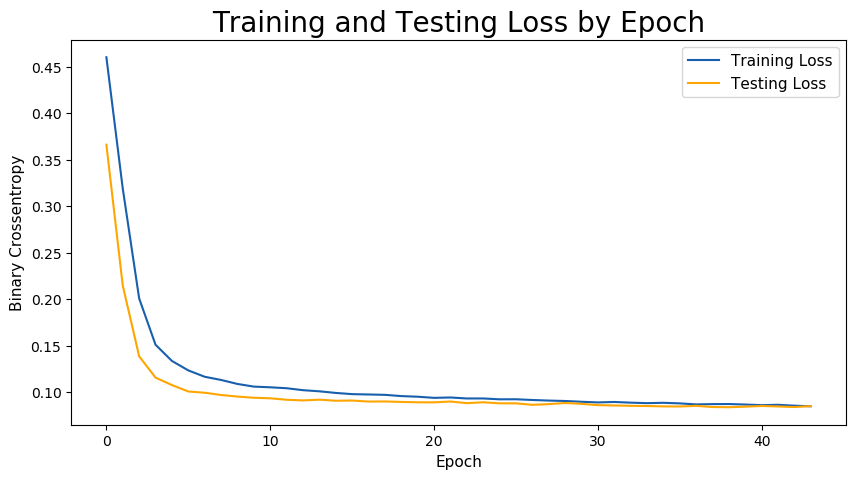

In [338]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Visualizing our training and testing loss by epoch
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 11)
plt.ylabel('Binary Crossentropy', fontsize = 11)
plt.legend(fontsize = 11);

# Credit to GA CNN global lecture author for the graph code 

**Interpretation:** The training and testing loss lines converge towards one another. This indicates that our model has stopped after approximately 45 epochs in order to avoid overfitting. 

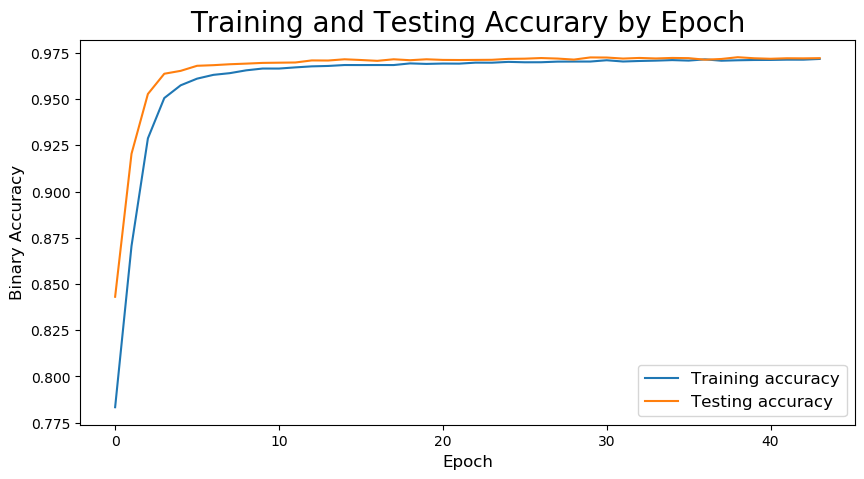

In [340]:
# Visualizing our training and testing accuracy by epoch:
plt.figure(figsize=(10, 5))
plt.plot(history.history['binary_accuracy'], label='Training accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Testing accuracy')
plt.title('Training and Testing Accurary by Epoch', fontsize = 20)
plt.xlabel('Epoch', fontsize = 12)
plt.ylabel('Binary Accuracy', fontsize = 12)
plt.legend(fontsize = 12);

**Interpretation:** While neural network models are built by minimizing loss, we must also look at accuracy since this is the metric we are evaluating our models on. We see that both training and testing accuracy increase as the number of epochs increase. Both lines then converge towards one another, suggesting that our model is not overfit. 

In [192]:
# Scoring
train_score = model.evaluate(X_train_sc,
                       y_train,
                       verbose=1)
test_score = model.evaluate(X_test_sc,
                       y_test,
                       verbose=1)
labels = model.metrics_names

print('')
print(f'Training Accuracy: {train_score[1]}')
print(f'Testing Accuracy: {test_score[1]}')

560/560 [==============================] - 1s 1ms/step - loss: 0.0851 - binary_accuracy: 0.9721

Training Accuracy: 0.9746546149253845
Testing Accuracy: 0.9721353650093079


**Interpretation:** Our model's training score of 97.5% is very close to our **97.2% accuracy testing score** meaning that our model is not overfit or underfit. The high testing score indicates that this model provides high predictive power.  
Note: More parameters than the ones appearing above were investigated during our search for the best model.

## Model Selection

As stated in our problem statement, we are looking for the model providing the highest accuracy. More specifically, we are looking for the model with the highest testing accuracy. Indeed, since our model will be used to classify new bookings, we need high predictive power on data our model has not been fitted on (never seen before). 

In [333]:
# Creating a dataframe to compare our models' performances:
predictive_model_scores = pd.DataFrame(data=[('Baseline',0.62960, 0.62961), ('Logistic Regression',0.81355, 0.81243), 
                                             ('Decision Tree',0.95904, 0.93556),('Bagging Classifier',0.99875, 0.96471), 
                                             ('Random Forest',0.92078, 0.91702), ('Neural Network',0.97465, 0.97214)],
                                       columns=['model', 'training_accuracy', 'testing_accuracy'])
predictive_model_scores

,model,training_accuracy,testing_accuracy
0,Baseline,0.62960,0.62961
1,Logistic Regression,0.81355,0.81243
2,Decision Tree,0.95904,0.93556
3,Bagging Classifier,0.99875,0.96471
4,Random Forest,0.92078,0.91702
5,Neural Network,0.97465,0.97214


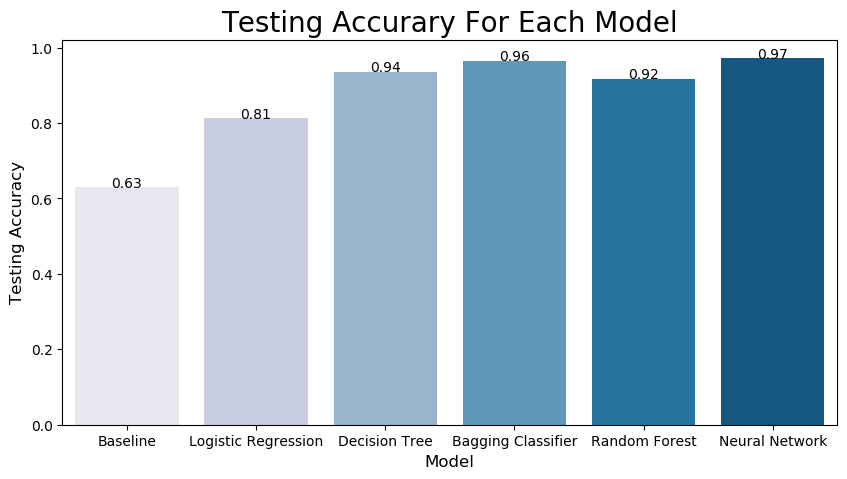

In [344]:
# Visualizing testing accuracy of each model: 
plt.style.use('default')
plt.figure(figsize=(10,5))
p=sns.barplot(x='model', y='testing_accuracy', data=predictive_model_scores, palette='PuBu')
plt.title('Testing Accurary For Each Model', fontsize = 20)
plt.xlabel('Model', fontsize = 12)
plt.ylabel('Testing Accuracy', fontsize = 12)
for index, row in predictive_model_scores.iterrows():
    p.text(x=row.name, y=row.testing_accuracy, s=round(row.testing_accuracy,2), color='black', horizontalalignment='center');

**The model providing the highest test accurary score is our Neural Network model**. Although our main goal is predictability, neural networks are "black boxes" and having a model that is interpretable can bring valuable insights.  Indeed, we mentioned the importance of engaging with the reasons why customers are cancelling. As a result, we will also evaluate our **Logistic Regression model for interpretability purposes**.  

## Model Evaluation

## Neural Network Evaluation

In [176]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                5248      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 7,361
Trainable params: 7,361
Non-trainable params: 0
_________________________________________________________________


**Interpretation:** Our neural network model includes 2 dense hidden layers, 2 dropout layers (to avoid overfitting), and one output dense layer. The model has a total of 7,361 parameters. 

### Confusion Matrix

In [346]:
# Making predictions
nn_predictions = model.predict_classes(X_test_sc)

# Creating confusion matrix 
cm = confusion_matrix(y_test, nn_predictions)

# putting the matrix a dataframe form  
cm_df = pd.DataFrame(cm, index=['Actually Not Canceled', 'Actually Canceled'],
                 columns=['Predicted Not Canceled', 'Predicted Canceled'])

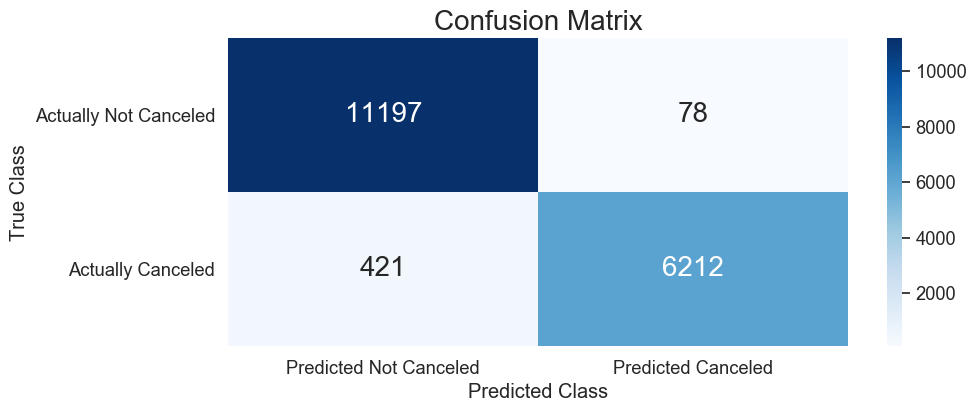

In [345]:
# visualizing the confusion matrix
sns.set(font_scale=1.2)
plt.figure(figsize=(10,4))
    
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues",xticklabels=cm_df.columns, yticklabels=cm_df.index, annot_kws={"size": 20})
plt.title("Confusion Matrix", size=20)
plt.xlabel('Predicted Class')
plt.ylabel('True Class');

In [44]:
# True Positives:
TP = 6212
# True Negatives:
TN = 11197
# False Posititives: 
FP = 78
# False Negatives: 
FN = 421
total = 6212+421+11197+78

print(f'Correctly classified: {np.round((TP+TN)/total*100)}%')
print(f'Canceled bookings correctly classified: {np.round(TP/(TP+FN)*100)}%')
print(f'Not canceled bookings correctly classified: {np.round(TN/(TN+FP)*100)}%')
print(f'Bookings predicted canceled that are actually canceled: {np.round(TP/(TP+FP)*100)}%')
print(f'Bookings predicted not canceled that are actually not canceled: {np.round(TN/(TN+FN)*100)}%')

Correctly classified: 97.0%
Canceled bookings correctly classified: 94.0%
Not canceled bookings correctly classified: 99.0%
Bookings predicted canceled that are actually canceled: 99.0%
Bookings predicted not canceled that are actually not canceled: 96.0%


**Interpretation:**   
Overall, we are correctly classifying 97% of the bookings. Looking more specifically at each category, we are correctly classifying 94% of the canceled bookings and 99% of the not canceled bookings. If our model predicted that a booking would be canceled, it was actually canceled in 99% of cases. If our model predicted that a booking would be not canceled, it was in fact not canceled in 96% of cases.   
Looking at the confusion matrix, we see that there are 78 bookings that our model predicted to be canceled that were not actually canceled. This means that in 0.4% of the cases, a guest may arrive and the hotel may not be ready for them or the hotel may risk overbooking if they were looking for a replacement guest.   
In addition, there are 421 bookings that our model predicted to be not canceled that were in fact canceled. This means that in 2.4% of cases, the hotel may be allocating their resources on the wrong reservations (getting a room ready that doesn't need to be or missing an opportunity to look for a replacement guest). 

### Understanding Misclassifications

In [376]:
# Creating a dataframe to compare our predictions to the actual subreddit
analysis = pd.DataFrame(y_test)
analysis['prediction'] = nn_predictions
prediction_analysis = pd.merge(left=analysis, right=X_test, on=analysis.index)

# Looking at the first 5 misclassified posts 
prediction_analysis[prediction_analysis['is_canceled'] != prediction_analysis['prediction']].head(2)

,key_0,is_canceled,prediction,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_h1,status_minus_arrival_date,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,clusters_The Cancelation Squad,clusters_The Extended Stay,clusters_The Family,clusters_The Return Customer
16,65898,1,0,90,2017,15,9,2,3,2,1,0,0,0,0,0,0,136.8,0,2,0,5,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
56,99003,0,1,31,2016,41,7,0,1,2,0,0,0,0,0,0,0,157.5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0


**Interpretation**  
- 1st misclassification (`key_0` 65898): This booking was misclassified as not canceled. The reservation features describe a booking for a family who made 2 special requests. We saw that families and people engaging with the hotel by making special requests are less likely to cancel which explains why our model predicted that this booking would not be canceled. 
- 2nd misclassification (`key_0` 99003): This booking was misclassified as canceled. Based on the short lead time, I would have thought that this booking would be classified as not canceled. The lack of engagement from the customer with the hotel (no booking changes, no request for parking, no special requests) may be a reason why this booking was classified as canceled. 

## Logistic Regression Evaluation

### Coefficients Interpretation

In [382]:
# Creating a dataframe of features and their associated logistic regression coefficients: 
coefficients = pd.DataFrame(lg.best_estimator_.coef_[0], X_train.columns)
coefficients.rename(columns = {0: 'coef'}, inplace=True)

In [384]:
# Filtering the ten features with the stongest coefficients 
top_coef = coefficients[(coefficients['coef'] > 1.8) | (coefficients['coef'] < -1.5)].copy()

# Adding the exponentiated coefficients 
top_coef['exp'] = np.exp(top_coef['coef'])
# Adding the percent likelihood calculation to interpret the coefficients 
top_coef['percent'] = (top_coef['exp']-1)*100
top_coef.sort_values('coef')

,coef,exp,percent
required_car_parking_spaces,-33.114923,4.153092e-15,-100.000000
assigned_room_type_I,-3.722331,2.417755e-02,-97.582245
assigned_room_type_G,-2.511495,8.114685e-02,-91.885315
assigned_room_type_F,-1.834961,1.596197e-01,-84.038034
assigned_room_type_K,-1.646038,1.928123e-01,-80.718767
assigned_room_type_H,-1.529293,2.166889e-01,-78.331111
reserved_room_type_G,1.927392,6.871569e+00,587.156920
previous_cancellations,2.956583,1.923215e+01,1823.215161
assigned_room_type_P,4.217111,6.783724e+01,6683.723636
deposit_type_Non Refund,5.176697,1.770968e+02,17609.684905


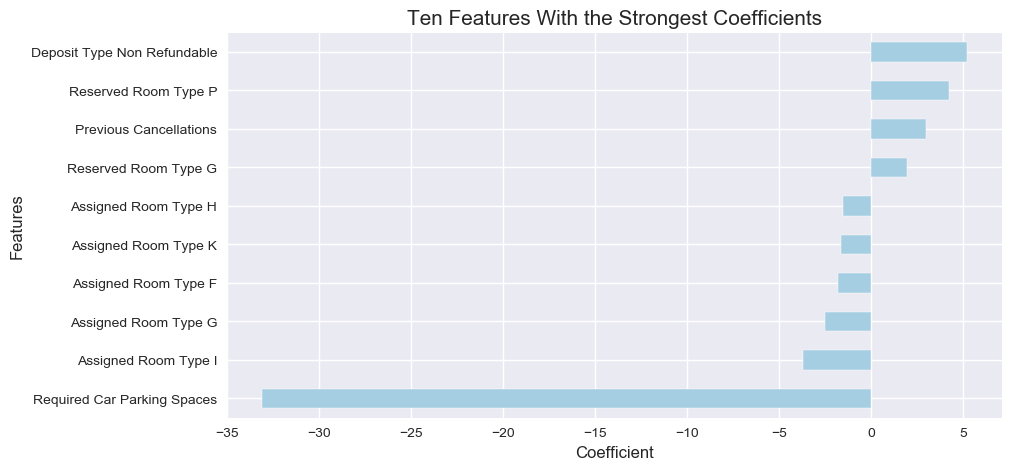

In [381]:
# Visualizing the 10 strongest coefficients 
plt.figure(figsize=(10,5), facecolor = 'w')
plt.style.use('seaborn')
top_coef.sort_values(by='coef')['coef'].plot(kind='barh', legend=None, cmap='Paired')
plt.title('Ten Features With the Strongest Coefficients', size=15)
plt.ylabel('Features', size=12)
plt.xlabel('Coefficient', size=12)
plt.yticks(np.arange(10), ['Required Car Parking Spaces', 'Assigned Room Type I', 'Assigned Room Type G', 
                           'Assigned Room Type F', 'Assigned Room Type K', 'Assigned Room Type H', 
                           'Reserved Room Type G', 'Previous Cancellations', 'Reserved Room Type P', 'Deposit Type Non Refundable']);

**Interpretation:**   
Making a non refundable deposit, reserving a room of type P or G, and having canceled a previous reservation are the four features that have the most weight in predicting that a booking will be canceled. It makes sense that having a history of cancellations would make a customer more likely to cancel their current booking. As discussed in the EDA section, the type of customers potentially required to make a non-refundable deposit may explain the link between this deposit type and cancellations.   
Requiring car parking spaces, and being assigned a room of type H, K, F, G, or I are the 6 features that have the most weight in predicting that a booking will not be canceled. As mentioned in the EDA section, a customer letting the hotel know that they require a parking space may be very confident in their destination or limited in their hotel choice due to the lack of parking at other hotels.     
As the room types were provided as code rather than the actually designation for anonymity purposes, it is hard to interpret the meaning of these features. Further collaboration and discussion with the hotels would be needed in order to make sense of the importance of those features. 

**Interpreting the 2 strongest coefficients:**
- For a 1 unit increase in the number of car parking spaces required, the booking would be 100% less likely to be canceled (all other features held constant). 
- If the deposit is of type "Non Refundable", the booking would be 177 times as likely to be canceled (all other features held constant).  

## Conclusion & Recommendations

We identified a Neural Network as the model giving us the highest predictive power. This model classifies whether or not a booking will be canceled with 97% accuracy. As a result, this model would allow hotels to more accurately forecast their occupancy, manage their business accordingly, and increase their revenue.   
Although our model has very high predictive power, it does have some shortcomings. Indeed, in 0.4% of cases, our model would classify a not canceled booking as canceled. This means that in 0.4% of cases, a hotel may not be expecting for a guest (and therefore not have planned accordingly for their arrival), or may even run the risk of being overbooked if their had looked for a replacement guest. In addition, in 2.4% of cases, our model would classify a canceled booking as not canceled. This means that in 2.4% of cases, a hotel may be getting ready for a guest that will not arrive and therefore allocating their resources to the wrong reservation.   
Our interpretative logistic regression model revealed that making a non-refundable deposit and requiring parking spaces are the two features influencing cancellation prediction the most. Our analysis also pointed at the importance of lead time, number of special requests, and room type.     
Moreover, we were able to identify 4 customer clusters: the cancellation squad, the family, the return customer, and the extended stay. Those clusters can be used for hotels to better prepare for their guests, engage with them in a more targeted manner, and give a sense of the cancellation risk.    
Finally, we discovered that a deeper understanding of the situation may require additional hotel specific information (such as surrounding parking availability or deposit policies). This suggests that working more closely with hotels directly and potentially building hotel specific models may be a good next step. 

## References

- [The Real Cost of Free Cancellations](https://triptease.com/blog/the-real-cost-of-free-cancellations/)     
- [Cancelation Rate at 40% as OTAs Push Free Change Policy](https://www.hotelmanagement.net/tech/study-cancelation-rate-at-40-as-otas-push-free-change-policy)
- [D-Edge Study: How Online Hotel Distribution is Changing in Europe](https://www.d-edge.com/how-online-hotel-distribution-is-changing-in-europe/) 
- [How Online reviews Impact Hotel Revenue](https://www.stayntouch.com/blog/how-online-reviews-impact-hotel-revenue/)
- [The Impact of Social Media on Lodging Performance](https://vtechworks.lib.vt.edu/handle/10919/85353)
- [Hotel Booking Demand Datasets](https://www.sciencedirect.com/science/article/pii/S2352340918315191)

I would also like to give credit to Mahdi Shadkam-Farrokhi and Noah Christiansen for their help and guidance. 